<a href="https://colab.research.google.com/github/DjoricMilica/PPPO/blob/main/Djoric_Milica_IT8_2018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projektni zadatak


*   Predmet: Principi prezentacije i prepoznavanja oblika 
*   Profesor: Arsenović Marko
*   Student: Đorić Milica IT8-2018
*   Tema: Klasifikacija

# Klasifikacija

U nauci o podacima, klasifikacija je zadatak mašinskog učenja koji za cilj ima dodeljivanje oznake (klase) ulaznim podacima. Primer zadatka klasifikovanja je prepoznavanje objekata na fotografijama (klasifikator fotorafija). Algoritmi za klasifikovanje se obučavaju korišćenjem označenih odnosno već klasifikovanih podataka. Ta vrsta obuke naziva se nadgledano mašinsko učenje. Nakon obuke, algoritam može da primi neoznačene slike kao ulaze i da izbaci oznake klasifikacije za svaku od njih. Algoritmi klasifikacije koriste matematičke i statističke metode za generisanje predviđanja o verovatnoći da će ulazni podaci biti klasifikovani na dati način. 

Postoje dve vrste klasifikatora fotografija.

Prva se zasniva na karakteristikama, gde algoritam generisanja (pretprocesiranja) izdvaja skup karakteristika fotografije koje se koriste za njeno predstavljanje. Algoritam za klasifikaciju fotografije se zatim koristi za klasifikaciju fotografije pomoću karakteristika.

Drugi tip klasifikatora je klasifikator dubokog učenja gde nije implementiran ni jedan korak predobrade (poput izdvajanja karakteristika), a duboka neuronska mreža od kraja do kraja je obučena za izvršavanje zadatka klasifikacije. 

# Set podataka

Cilj projekta jeste kreiranje modela koji će na osnovu slike lista izvršiti klasifikovanje biljke, odnosno utvrditi o kojoj vrsti biljke je reč. Klasifikaciju je moguće vršiti na osnovu slika koje se nalaze u dobijenom setu ili na osnovu karakteristika zapisanih u csv formatu.    

# Učitavanje podataka

Prikaz svih neophodnih import-a

In [1]:
from google.colab import drive
import os
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import load_img
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

Folder sa dobijenim podacima (#4) je unzip-ovan, a zatim je postupak ponovljen i za ostale foldere unutar njega(images, train.csv, test.csv i sample_submission). Folderi su dodati na Google Drive nalog koji je zatim povezan sa Google Colab-om.  

In [2]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Naredna linija koda ispisuje sve direktorijume koji se nalaze na prosleđenoj putanji na drajvu. Ta putanja vodi do derektorijuma #4. Rezultat je očekivan čime se potvrđuje da su podaci uspešno dodati na Google Drive.

In [3]:
os.listdir('/content/gdrive/My Drive/Colab Notebooks/#4')

['images.zip',
 'train.csv.zip',
 'test.csv.zip',
 'sample_submission.csv.zip',
 'train.csv',
 'sample_submission.csv',
 'images',
 'test.csv']

U varijable images, train, test i sample_submission su dodate putanje do istoimenih foldera. Jednostavnije je da budu zapisane na jednom mestu, ukoliko bi došlo do promene.

In [4]:
images = "/content/gdrive/MyDrive/Colab Notebooks/#4/images"
test = "/content/gdrive/MyDrive/Colab Notebooks/#4/test.csv/test.csv"
train = "/content/gdrive/MyDrive/Colab Notebooks/#4/train.csv/train.csv"
sample_submission = "/content/gdrive/MyDrive/Colab Notebooks/#4/sample_submission.csv/sample_submission.csv"

**Sadržaj foldera images**

U ovom folderu nalaze slike listova na osnovu kojih se određuje klasa kojoj pripada biljka. Narednom komandom dolazi se do infromacije da folder sadrži ukupno 1584 slika listova.

In [5]:
len(os.listdir(images))

1584

Kako bi se stekao uvid u slike iz fodera pokrenuta je sledeća linija koda. Ona rezultije prikazom 20 slučajno izabranih slika iz foldera images u formatu 15x15. Može se primetiti da su slike sa crnom pozadinom i belim listovima, da su listovi različitih oblika i da su neki pozicionirani horzontalno, a neki vertikalno.

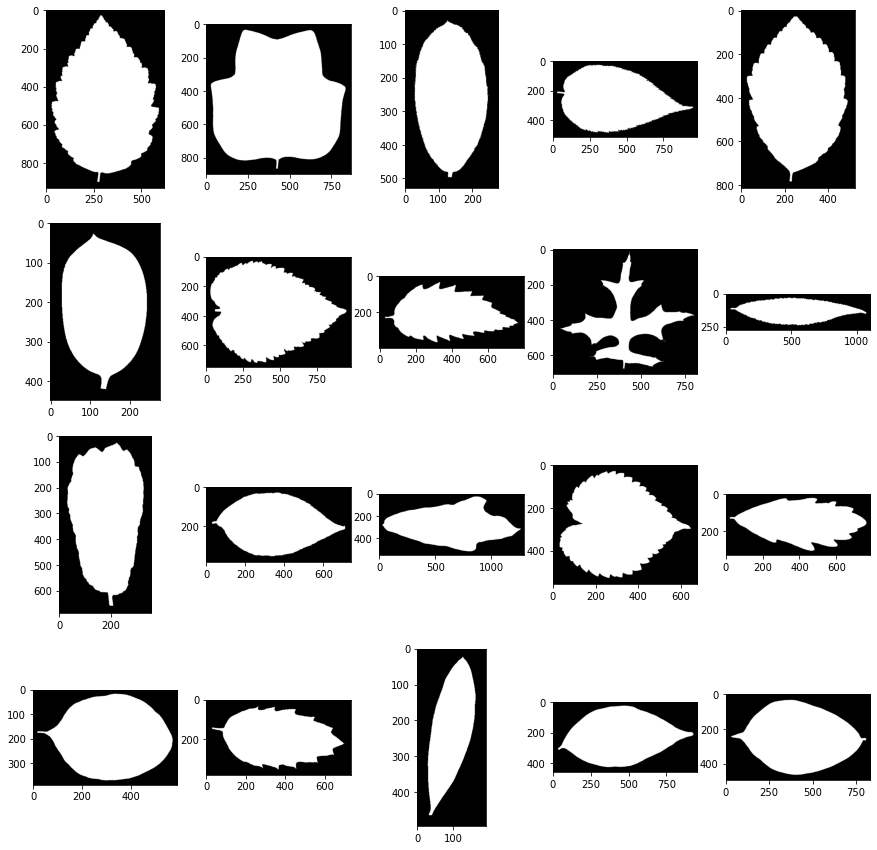

In [6]:
plt.figure(figsize=(15,15))
for i in range(20):
    j=np.random.choice((os.listdir(images)))
    plt.subplot(4,5,i+1)
    img=load_img(os.path.join(images,j))
    plt.imshow(img)

**Sadžaj fajlova train_csv i test_csv**

Za učitavanje csv fajlova koristi se pandas. Sadržaj ovih fajlova smešten je u varijavle df_train i df_test. Pozvana je metoda read_csv kojoj su prosleđena dva parametra. Prvi je putanja do csv fajla, a drugi govori o tome da se prva kolona ne koristi kao ID. U ovim fajlovima nalaze se podaci koji će se koristiti za treniranje i testiranje.

In [7]:
df_train = pd.read_csv(train, index_col=False)
df_test = pd.read_csv(test, index_col=False)

Funkcije columns, head i describe omogućavaju da se opiše sadržaj fajlova. Columns vraća sve kolone (polja), head prikazuje prvih 5 redova fajla, a describe vraća osnovne statističke parametre kao što su minimum, maksimum, standardna devjacija, srednja vrednost i tako dalje.  

Pozivom funkcije columns nad trening i test setom zaključuje se da test set podataka ne sadrži kolonu pod nazivom species. Kada se model trenira potrebno je da mu se prosledi i rezultat klasifikovanja (nadgledano mašinsko učenje). To znači da se prilikom obučavanja modela za svaku instancu  prosleđuje podatak o tome kojoj klasi pripada. Kada se vrši testiranje obučenog modela, rezultat klasifikacije se krije od njega. 

In [8]:
df_train.columns

Index(['id', 'species', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5',
       'margin6', 'margin7', 'margin8',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=194)

In [9]:
df_test.columns

Index(['id', 'margin1', 'margin2', 'margin3', 'margin4', 'margin5', 'margin6',
       'margin7', 'margin8', 'margin9',
       ...
       'texture55', 'texture56', 'texture57', 'texture58', 'texture59',
       'texture60', 'texture61', 'texture62', 'texture63', 'texture64'],
      dtype='object', length=193)

Poziv funkcije describe ukazuje na to da su vrednosti margin-a i texture-a numeričke i da su u rasponu od 0 do 1. 

In [10]:
df_train.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,...,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000,990.000000
mean,799.595960,0.017412,0.028539,0.031988,0.023280,0.014264,0.038579,0.019202,0.001083,0.007167,...,0.036501,0.005024,0.015944,0.011586,0.016108,0.014017,0.002688,0.020291,0.008989,0.019420
std,452.477568,0.019739,0.038855,0.025847,0.028411,0.018390,0.052030,0.017511,0.002743,0.008933,...,0.063403,0.019321,0.023214,0.025040,0.015335,0.060151,0.011415,0.039040,0.013791,0.022768
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,415.250000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,802.500000,0.009766,0.011719,0.025391,0.013672,0.007812,0.015625,0.015625,0.000000,0.005859,...,0.004883,0.000000,0.005859,0.000977,0.012695,0.000000,0.000000,0.003906,0.002930,0.011719
75%,1195.500000,0.025391,0.041016,0.044922,0.029297,0.017578,0.056153,0.029297,0.000000,0.007812,...,0.043701,0.000000,0.022217,0.009766,0.021484,0.000000,0.000000,0.023438,0.012695,0.029297
max,1584.000000,0.087891,0.205080,0.156250,0.169920,0.111330,0.310550,0.091797,0.031250,0.076172,...,0.429690,0.202150,0.172850,0.200200,0.106450,0.578130,0.151370,0.375980,0.086914,0.141600


In [11]:
df_test.describe()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
count,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,...,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000,594.000000
mean,780.673401,0.017562,0.028425,0.031858,0.022556,0.014527,0.037497,0.019222,0.001085,0.007092,...,0.035291,0.005923,0.015033,0.011762,0.015881,0.011217,0.002617,0.019975,0.009389,0.020970
std,465.646977,0.019585,0.038351,0.025719,0.028797,0.018029,0.051372,0.017122,0.002697,0.009515,...,0.064482,0.026934,0.022318,0.024771,0.014898,0.052530,0.011204,0.034704,0.013457,0.023407
min,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,368.500000,0.001953,0.001953,0.013672,0.005859,0.001953,0.000000,0.005859,0.000000,0.001953,...,0.000000,0.000000,0.000977,0.000000,0.004883,0.000000,0.000000,0.000000,0.000000,0.000977
50%,774.000000,0.009766,0.010743,0.023438,0.013672,0.007812,0.013672,0.015625,0.000000,0.005859,...,0.003906,0.000000,0.005859,0.001953,0.012695,0.000000,0.000000,0.003418,0.002930,0.013184
75%,1184.500000,0.028809,0.041016,0.042969,0.027344,0.019531,0.056641,0.029297,0.000000,0.007812,...,0.038086,0.000000,0.019531,0.010498,0.022461,0.000000,0.000000,0.022461,0.014648,0.032227
max,1583.000000,0.085938,0.189450,0.167970,0.164060,0.093750,0.271480,0.087891,0.021484,0.083984,...,0.353520,0.441410,0.153320,0.177730,0.083984,0.606450,0.123050,0.247070,0.086914,0.149410


Head fukcija prikazije prvih 5 redova fajla. Podaci koji se nalaze u test setu ne nalaze se u trening setu i obrnuto. To se vidi po vrednostima u koloni id.

In [12]:
df_train.head()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,Acer_Opalus,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,2,Pterocarya_Stenoptera,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,3,Quercus_Hartwissiana,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,5,Tilia_Tomentosa,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,6,Quercus_Variabilis,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


In [13]:
df_test.head()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


**Sadržaj folder sample_submission**

In [14]:
df_sample=pd.read_csv(sample_submission,index_col=False)

In [15]:
df_sample

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,4,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
1,7,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
2,9,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
3,12,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
4,13,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1576,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
590,1577,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


# Mogući pristupi

# Priprema podataka

Priprema podataka za obučavanje modela podrazumeva nekoliko koraka. Prvi od njih jeste obrada null odnosno nedostajućih vrednosti. U narednim linijama koda se sumiraju po kolonama null vrednosti. Kako su rezultati jednaki 0, nedostajućih vrednosti nema i njihova dalja obrada nije neophodna.

In [16]:
df_train.isnull().sum()

id           0
species      0
margin1      0
margin2      0
margin3      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 194, dtype: int64

In [17]:
df_test.isnull().sum()

id           0
margin1      0
margin2      0
margin3      0
margin4      0
            ..
texture60    0
texture61    0
texture62    0
texture63    0
texture64    0
Length: 193, dtype: int64

Sledeće što je potrebno uraditi jeste enkodovanje vrednosti koje nisu numeričke. Samo kolona u okviru trening seta podatak sadrži nenumeričke podatke, pa su njene karakteristike detaljnije ispitane u nastavku. Narednom komandom prikazane su sve vrednosti (to su konkretne klase biljaka u ovom slučaju) kolone species bez ponavljanja.

In [18]:
print(np.unique(df_train.species))

['Acer_Capillipes' 'Acer_Circinatum' 'Acer_Mono' 'Acer_Opalus'
 'Acer_Palmatum' 'Acer_Pictum' 'Acer_Platanoids' 'Acer_Rubrum'
 'Acer_Rufinerve' 'Acer_Saccharinum' 'Alnus_Cordata' 'Alnus_Maximowiczii'
 'Alnus_Rubra' 'Alnus_Sieboldiana' 'Alnus_Viridis' 'Arundinaria_Simonii'
 'Betula_Austrosinensis' 'Betula_Pendula' 'Callicarpa_Bodinieri'
 'Castanea_Sativa' 'Celtis_Koraiensis' 'Cercis_Siliquastrum'
 'Cornus_Chinensis' 'Cornus_Controversa' 'Cornus_Macrophylla'
 'Cotinus_Coggygria' 'Crataegus_Monogyna' 'Cytisus_Battandieri'
 'Eucalyptus_Glaucescens' 'Eucalyptus_Neglecta' 'Eucalyptus_Urnigera'
 'Fagus_Sylvatica' 'Ginkgo_Biloba' 'Ilex_Aquifolium' 'Ilex_Cornuta'
 'Liquidambar_Styraciflua' 'Liriodendron_Tulipifera'
 'Lithocarpus_Cleistocarpus' 'Lithocarpus_Edulis' 'Magnolia_Heptapeta'
 'Magnolia_Salicifolia' 'Morus_Nigra' 'Olea_Europaea' 'Phildelphus'
 'Populus_Adenopoda' 'Populus_Grandidentata' 'Populus_Nigra'
 'Prunus_Avium' 'Prunus_X_Shmittii' 'Pterocarya_Stenoptera'
 'Quercus_Afares' 'Querc

Zatim su klase biljaka prebrojane, ima 99 različitih.

In [19]:
len(np.unique(df_train.species))

99

Sledeća linija koda nakon izvršavanja prikazuje koliko biljaka u trening setu pripada svakoj klasi. Reultati su ujednačeni, u trening set je smešteno za svaku kalsu biljaka po 10 instanci.

In [20]:
df_train["species"].value_counts()

Acer_Opalus                    10
Crataegus_Monogyna             10
Acer_Mono                      10
Magnolia_Heptapeta             10
Acer_Capillipes                10
                               ..
Alnus_Rubra                    10
Rhododendron_x_Russellianum    10
Cytisus_Battandieri            10
Liriodendron_Tulipifera        10
Sorbus_Aria                    10
Name: species, Length: 99, dtype: int64

Narednom linijom koda izvršeno je enkodovanje vrednosti u koloni species. Korišćen je LabelEnkoder. Enkodirane su vrednosti u data farme-u df_train, a iste vrednosti su sačuvane u posebnoj varijabli labels kako bi se lakše koristile u nastavku.

In [21]:
encoder=LabelEncoder()
lb=encoder.fit(df_train.species)
species_in_train = df_train.species #sačuvani nazivi klasa iz train skupa
df_train.species=lb.transform(df_train.species) #enkodirani species
labels = df_train.species 

Prikazan je trening set podataka ali sada sa enkodovanim vrednostima u koloni species.

In [22]:
df_train

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,1,3,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.000000,0.000000,0.004883,0.000000,0.025391
1,2,49,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.000000,0.000000,0.000977,0.039062,0.022461
2,3,65,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.000000,0.000000,0.000000,0.020508,0.002930
3,5,94,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.000000,0.000000,0.017578,0.000000,0.047852
4,6,84,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.031250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,1575,40,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,5,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,11,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,78,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930


U toku treniranja i testiranja modela, kolone koja sadrže id-jeve neće biti potrebne, pa se sa trenutnih data frame-ova uklanjaju. 

In [23]:
test_id = df_test.id
df_test = df_test.drop(["id"],axis=1)

In [24]:
df_train = df_train.drop(["id"],axis=1)

Kako bi obuka modela bila uspešna, trening set podataka je podeljen u dva seta. Prvi od njih se naziva set za obuku i on obuhvata 80% početnog seta, a drugi se naziva validacioni set i on sadrži ostatak podataka. Fukcija train_test_split prihvata sledeće: podatke na osnovu kojih se vrši klasifikacija (to je df_train bez kolone koja sadrži klase); podatke koji su rezultati predviđanja (to su enkodovane vrednosti kolone species koje su prethodno smeštene u varijablu labels); veličinu validacionog testa što je 0.20

In [25]:
X_train, X_test, y_train, y_test=train_test_split(df_train.drop(["species"],axis=1),labels,test_size=0.20,shuffle=True,stratify=labels)



*   X_train sadrži 80% podataka na osnovu kojih se klasifikuje
*   X_test sadrži 20% podataka na osnovu kojih se klasifikuje

Nad ovim varijablama je pozvana fukcija shape kako bi se proverio broj instanci.





In [26]:
X_train.shape

(792, 192)

In [27]:
X_test.shape

(198, 192)

# Obučavanje modela

Kada su podaci pripremljeni prelazi se na obučavanje modela. Nekoliko modela je kreirano, a zatim je izabran onaj koji daje najbolje rezultate.

Kreirana je metoda pod nazivom evaluate koja kao parametar prihvata model. U okviru metode izvršava se fit-ovanje modela i kros validacija. Zatim se ispisuje naziv model i njegova tačnost. Ova metoda daje uvid u to koji model daje koliku tačnost.

Metoda fit prihvata podatke za obuku i podatke, u ovom slučaju to su dva niza jer je reč o nadgledanom mašinskom učenju. 

Za određivanje performanse upotrebljenog modela, koristi se trening skup podataka, nad kojim se primenjuje tehnika pod nazivom unakrsna validacija (cross validation). Ova tehnika podrazumeva da se trening skup podataka podeli na 𝑘 delova približno iste veličine, a zatim se 𝑘 − 1 delova koristi kao skup za učenje a preostali deo kao skup za validaciju. Postupak se ponavlja 𝑘 puta tako da svaki od delova po jednom učestvuje u ulozi validacionog skupa.



In [28]:
def evaluate(model):
    model.fit(X_train,y_train)
    scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=5, n_jobs=-1)
    
    print('Model ',model)
    print('Accuracy ', np.mean(scores)*100)

U narednoj ćeliji inicijalizovani su modeli koji su smešteni u niz. Za svaki model iz niza pozvana je prethodno definisana metoda evaluate. Rezultati pokazuju da je RandomForestClassifier najtačniji. 

Korišćena su tri algoritma za klasifikaciju:


1. SGD Classifier je linearni klasifikator koji koristi stohastički gradijentni spust prilikom treniranja. On računa gradijent funkcije gubitka i  ažurira model promenom parametara modela kako bi minimizovao fukciju gubitka. Stohastički gradijentni spust je iterativna metoda za optimizaciju funkcije gubitka.To je ustvari stohastička aproksimacija gradijentnog spusta (gradijent se ne računa nad svim podacima već samo nad jednim delom)
2. Random Forest Classifier je algoritam koji gradi određeni broj stabla odlučivanja. Stablo odlučivanja se sastoji iz čvorova, listova i grana. U čvorovima se nalaze instance podataka. Za svaku gradu je definisan uslov u vidu vrednosti obeležja instance. U listovima stabla nalaze se vrednosti klase.
1. KNeighbors Classifier je algoritam k najbližih suseda koji klasifikuje instancu posmatrajući k njenih najbližih suseda(drugih instanci). Instanca se klasifikuje na osnovu klase kojoj pripada največi broj od njenih k suseda.









In [29]:
RFC = RandomForestClassifier(n_estimators=150)
SGDC = SGDClassifier(loss="hinge")
KNC = neighbors.KNeighborsClassifier(n_neighbors=10)

models =[RFC,SGDC,KNC]
for model in models:
  evaluate(model)


Model  RandomForestClassifier(n_estimators=150)
Accuracy  97.8560624154128
Model  SGDClassifier()
Accuracy  58.46827481888385
Model  KNeighborsClassifier(n_neighbors=10)
Accuracy  75.1317570257145


Za svaki od pomenuta tri modela izvršena je optimizacija putem hiperparametara. Performanse modela značajno zavise od vrednosti hiperparametara, ali ne postoji način da se unapred zadaju najbolje vrednosti. Zato je potrebno ispitati više njih, idealno bi bilo ispitati sve moguće vrednosti. Ako se ispitivanje radi ručno, potrebno je dosta vremena i resursa i zbog toga je upotrebljen  GridSearchCV da bi se automatizovalo podešavanje hiperparametara.  

GridSearchCV je proces izvođenja podešavanja hiperparametara u cilju određivanja njihovih optimalnih vrednosti za dati model. Ova funkcija pomaže da se prođe kroz unapred definisane hiperparametre i da se oni uklope u model kako bi se na kraju izveli najbolji parametri od navedenih hiperparametara. Metoda GridSearchCV prihvata model, listu hiperparametra i tip scoring-a što je u ovom slučaju accuracy (tačnost).

Nakon optimizacije modela, za svaki je pozvana metoda evaluate.

In [30]:
#RFC = RandomForestClassifier(n_estimators=150) 
param_list = {'min_samples_leaf':[3,6,9], 'max_depth': [10,20,None], 'criterion' : ['gini', 'entropy']}

search = GridSearchCV(RFC, param_list, scoring='accuracy')
result = search.fit(X_train, y_train)

print('Najbolji rezultat: %s' % result.best_score_)
print('Najbolji hiperparametri: %s' % result.best_params_)
print('Najbolji estimator: %s' % result.best_estimator_)

Najbolji rezultat: 0.9710054931932172
Najbolji hiperparametri: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}
Najbolji estimator: RandomForestClassifier(min_samples_leaf=3, n_estimators=150)


In [31]:
optimized_RFC = search.best_estimator_ 
evaluate(optimized_RFC)

Model  RandomForestClassifier(min_samples_leaf=3, n_estimators=150)
Accuracy  96.72398694371468


In [32]:
#SGDC = SGDClassifier(loss="hinge") 
param_list = {'penalty':['l1','l2','elasticnet'], 
              'alpha': [ 0.00001, 0.0001, 0.001],
              'loss' : ['hinge', 'log',  'perceptron']}
              #'eta0' : [1, 10, 100]}

search = GridSearchCV(SGDC, param_list, scoring='accuracy')
result = search.fit(X_train, y_train)

print('Najbolji rezultat: %s' % result.best_score_)
print('Najbolji hiperparametri: %s' % result.best_params_)
print('Najbolji estimator: %s' % result.best_estimator_)

Najbolji rezultat: 0.8812753761643182
Najbolji hiperparametri: {'alpha': 1e-05, 'loss': 'log', 'penalty': 'l1'}
Najbolji estimator: SGDClassifier(alpha=1e-05, loss='log', penalty='l1')


In [33]:
optimized_SGDC = search.best_estimator_ 
evaluate(optimized_SGDC)

Model  SGDClassifier(alpha=1e-05, loss='log', penalty='l1')
Accuracy  87.24623835681872


In [34]:
#KNC = neighbors.KNeighborsClassifier(n_neighbors=10)
param_list = {'n_neighbors' : [10,15,5],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}

search = GridSearchCV(KNC, param_list, scoring='accuracy')
result = search.fit(X_train, y_train)

print('Najbolji rezultat: %s' % result.best_score_)
print('Najbolji hiperparametri: %s' % result.best_params_)
print('Najbolji estimator: %s' % result.best_estimator_)

Najbolji rezultat: 0.9166547249422816
Najbolji hiperparametri: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Najbolji estimator: KNeighborsClassifier(metric='manhattan', weights='distance')


In [35]:
optimized_KNC = search.best_estimator_ 
evaluate(optimized_KNC)

Model  KNeighborsClassifier(metric='manhattan', weights='distance')
Accuracy  91.66547249422817


Nakon optimizacije, zaključuje se da najbolji rezultat vraća optimizovani RandomForest Classifier. U narednoj liniji ispisani su skorovi optimizovanih modela nad testnim podacima. 

In [36]:
print(optimized_RFC.score(X_test,y_test)*100)
print(optimized_SGDC.score(X_test,y_test)*100)
print(optimized_KNC.score(X_test,y_test)*100)

0.9797979797979798
0.9141414141414141
0.9747474747474747


Izvršena je predikcija upotrebom modela sa najboljim rezultatom nad validacionim podacima. Rezultat je prikazan putem tabele. U prvoj koloni se nalaze stvarni rezultati, a u drugoj rezultati koje je predvideo model. Na osnovu vrednosti može se zaključiti da je validacija uspešna.

In [37]:
y_pred = optimized_RFC.predict(X_test)

In [46]:
pd.DataFrame({'Stvarni rezultati': y_test,                   
               'Rezultati koje daje model': y_pred})

,Stvarni rezultati,Rezultati koje daje model
798,63,63
763,97,97
44,23,23
263,31,31
348,8,8
...,...,...
852,65,65
837,30,30
940,19,19
631,1,1


# Predikcija i prikaz rezultata

Sledeći korak jeste predikacija najbolje ocenjenim modelom nad skupom podataka za testiranje. Kolona koja sadži vrednosti id-jeva za listove iz seta podataka za testiranje vraćena je, i dodata joj je kolona sa labelama - enkodiranim vrednostima klasa (vrste biljaka). Na samom kraju konačno rešenje je prikazano u formatu koji prikazuje vrednosti karakteristika za svaki list, njegov id, enkodiranu vrednost klase.

In [38]:
predicted = optimized_RFC.predict(df_test)

In [47]:
output = pd.DataFrame({'Id': test_id,
                       'Labels': predicted})

In [48]:
final=pd.concat([output,df_test],axis=1)
final.head()

,Id,Labels,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,4,51,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,7,50,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,9,1,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,12,19,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,13,14,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


# Literatura



*   https://www.mygreatlearning.com/blog/gridsearchcv/
*   https://scikit-learn.org/stable/user_guide.html
*   https://www.ritchieng.com/machine-learning-efficiently-search-tuning-param/
*   Prezentacija sa vežbi na temu klasifikacije



